# Lookahead-study | Tumor model (M1)

In [1]:
import pyabc
import cProfile
import numpy as np
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
from pyabc import History
import logging
import matplotlib.patches as mpatches
from pathlib import Path
from pyabc.weighted_statistics import weighted_quantile
import tumor2d

samplers_color =["#8AA8A1", "#885A89", "#CBCBD4"]
samplers_color_double =["#8AA8A1", "#885A89", "#CBCBD4", "#8AA8A1", "#885A89", "#CBCBD4"]
sampler_labels = ["DYN", "LA Pre", "LA Cur"]
colors_map = {'LA':samplers_color[2], 'DYN':samplers_color[0], 'LA_pre':samplers_color[1]}         
colors = [samplers_color[0], samplers_color[0], samplers_color[1],
          samplers_color[1], samplers_color[2] , samplers_color[2]]
colors_map_eps = {'TumorRes500_256':samplers_color[2], 'TumorRes1000_256':samplers_color[2],
              'TumorRes_ori500_256':samplers_color[0], 'TumorRes_ori1000_256':samplers_color[0],
             'TumorRes_old500_256':samplers_color[1], 'TumorRes_old1000_256':samplers_color[1]}         


## 256 cores on population size of = 1000 and 500 (Eps <1.52e+03)

In [2]:
gp = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M1/database"


In [3]:
h = pyabc.History(f"sqlite:///{gp}/TumorRes1000_256_1.db", create=False)
abc = h.get_abc()
print("1000_256= "+str((h.get_all_populations()["population_end_time"][28] - abc.start_time).total_seconds()))

h = pyabc.History(f"sqlite:///{gp}/TumorRes500_256_1.db", create=False)
abc = h.get_abc()
print("500_256= "+str((h.get_all_populations()["population_end_time"][29] - abc.start_time).total_seconds()))

1000_256= 72386.901194
500_256= 29179.073467


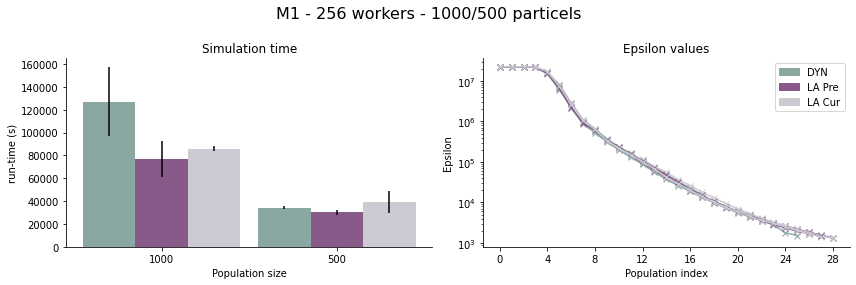

In [4]:

pyabc.settings.set_figure_params("pyabc")

sampler_labels = ["TumorRes1000_256", "TumorRes_ori1000_256", "TumorRes_old1000_256",
                  "TumorRes500_256", "TumorRes_ori500_256", "TumorRes_old500_256"]



sampler = "data_la"
model_id = "TumorRes"

pop_size = 1000
worker_size = 256
sigma = 0.5
iters = 2


population_index = {"TumorRes1000_256_1": 29, "TumorRes1000_256_2": 29,
                    "TumorRes_ori1000_256_1": 29, "TumorRes_ori1000_256_2": 26,
                    "TumorRes_old1000_256_1": 28,"TumorRes_old1000_256_2": 28,
                   "TumorRes500_256_1": 29, "TumorRes500_256_2": 29, 
                    "TumorRes_ori500_256_1": 28, "TumorRes_ori500_256_2": 29,
                    "TumorRes_old500_256_1": 29,"TumorRes_old500_256_2": 28,
}
times = []
time_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
#         print("sampler:", sampler_label + "_" + str(ix+1))
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_label + "_" + str(ix+1)]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
    time_new[sampler_label] = times_for_sampler
    times.append(times_for_sampler)

times = np.array(times)
times /= np.max(np.mean(times, axis=1))
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))


x = np.arange(2)
f_width = 0.3

axes[0].bar(
    x-f_width,
    height=[np.mean(time_new["TumorRes_ori1000_256"]), np.mean(time_new["TumorRes_ori500_256"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes_ori1000_256"]), np.std(time_new["TumorRes_ori500_256"])],
    color=colors_map["DYN"]
)
axes[0].bar(
    x,
    height=[np.mean(time_new["TumorRes_old1000_256"]), np.mean(time_new["TumorRes_old500_256"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes_old1000_256"]), np.std(time_new["TumorRes_old500_256"])],
    color=colors_map["LA_pre"]
)
axes[0].bar(
    x+f_width,
    height=[np.mean(time_new["TumorRes1000_256"]), np.mean(time_new["TumorRes500_256"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes1000_256"]), np.std(time_new["TumorRes500_256"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['1000', '500'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")



# axes[0].bar(
#     x=np.arange(4),
#     height=np.mean(time_new[]),
#     yerr=np.std(times, axis=1),
#     color=colors,label=["1", "2", "3", "4"]
# )

# labels = list(colors_map.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors_map[label]) for label in labels]
# axes[0].legend(handles, labels)


db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M1 - {worker_size} workers - 1000/500 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M1_figures/M1_time_epsilon_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [5]:
LA_pre_mean_256 = []
LA_curr_mean_256 = []
DYN_mean_256 = []
LA_pre_mean_256 = time_new["TumorRes_old500_256"] + time_new["TumorRes_old1000_256"]
LA_curr_mean_256 = time_new["TumorRes500_256"] + time_new["TumorRes1000_256"]
DYN_mean_256 = time_new["TumorRes_ori500_256"] + time_new["TumorRes_ori1000_256"]

LA_pre_median_256 = []
LA_curr_median_256 = []
DYN_median_256 = []
LA_pre_median_256 = time_new["TumorRes_old500_256"] + time_new["TumorRes_old1000_256"]
LA_curr_median_256 = time_new["TumorRes500_256"] + time_new["TumorRes1000_256"]
DYN_median_256 = time_new["TumorRes_ori500_256"] + time_new["TumorRes_ori1000_256"]


## 128 cores on population size of = 500 and 250 (Eps <1.49e+03)

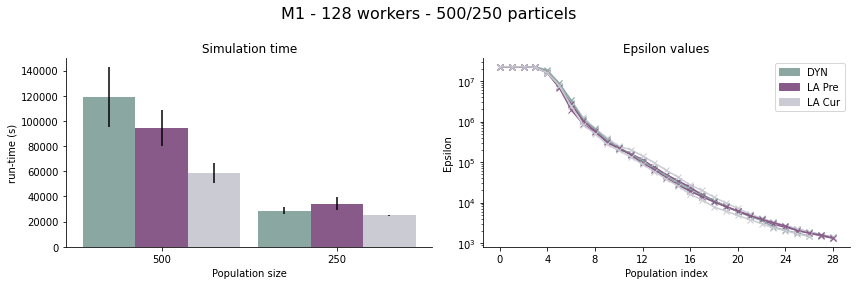

In [6]:
import pyabc
import matplotlib.pyplot as plt
import numpy as np

pyabc.settings.set_figure_params("pyabc")


sampler_labels = ["TumorRes500_128", "TumorRes_ori500_128", "TumorRes_old500_128",
                  "TumorRes250_128", "TumorRes_ori250_128", "TumorRes_old250_128"
                 ]



sampler = "data_la"
model_id = "TumorRes"

pop_size = 500
worker_size = 128

sigma = 0.5
iters = 2


population_index = {"TumorRes500_128_1": 29, "TumorRes500_128_2": 29,
                    "TumorRes_ori500_128_1": 29, "TumorRes_ori500_128_2": 27,
                    "TumorRes_old500_128_1": 29,"TumorRes_old500_128_2": 27,
                   "TumorRes250_128_1": 27, "TumorRes250_128_2": 27, 
                    "TumorRes_ori250_128_1": 28, "TumorRes_ori250_128_2": 28,
                    "TumorRes_old250_128_1": 29,"TumorRes_old250_128_2": 27,
}
times = []
time_new = {}
for sampler_label in sampler_labels:
    times_for_sampler = []
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
#         print("sampler:", sampler_label + "_" + str(ix+1))
        abc = h.get_abc()
        if abc.end_time is None:
            times_for_sampler.append(
                (h.get_all_populations()["population_end_time"][population_index[sampler_label + "_" + str(ix+1)]] - abc.start_time).total_seconds())
        else:
            times_for_sampler.append(
                (abc.end_time - abc.start_time).total_seconds())
    time_new[sampler_label] = times_for_sampler
    times.append(times_for_sampler)

times = np.array(times)
times /= np.max(np.mean(times, axis=1))
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))


x = np.arange(2)
f_width = 0.3

axes[0].bar(
    x-f_width,
    height=[np.mean(time_new["TumorRes_ori500_128"]), np.mean(time_new["TumorRes_ori250_128"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes_ori500_128"]), np.std(time_new["TumorRes_ori250_128"])],
    color=colors_map["DYN"]
)
axes[0].bar(
    x,
    height=[np.mean(time_new["TumorRes_old500_128"]), np.mean(time_new["TumorRes_old250_128"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes_old500_128"]), np.std(time_new["TumorRes_old250_128"])],
    color=colors_map["LA_pre"]
)
axes[0].bar(
    x+f_width,
    height=[np.mean(time_new["TumorRes500_128"]), np.mean(time_new["TumorRes250_128"])],
    width = f_width,
    yerr=[np.std(time_new["TumorRes500_128"]), np.std(time_new["TumorRes250_128"])],
    color=colors_map["LA"]
)

axes[0].set_xticks(x, ['500', '250'])
axes[0].set_xlabel("Population size")
axes[0].set_ylabel("run-time (s)")
# axes[0].legend(["LA", "DYN", "LA_pre"])
axes[0].set_title("Simulation time")



# axes[0].bar(
#     x=np.arange(4),
#     height=np.mean(time_new[]),
#     yerr=np.std(times, axis=1),
#     color=colors,label=["1", "2", "3", "4"]
# )

# labels = list(colors_map.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors_map[label]) for label in labels]
# axes[0].legend(handles, labels)


db_list = []
for sampler_ix, sampler_label in enumerate(sampler_labels):
    for ix in range(iters):
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_label}_{str(ix+1)}.db", create=False)
        db_list.append(h)
pyabc.visualization.plot_epsilons(db_list, ax=axes[1], colors=samplers_color_double)
labels = list(colors_map.keys())

DYN_patch = mpatches.Patch(color=samplers_color[0], label='DYN')
Pre_patch = mpatches.Patch(color=samplers_color[1], label='LA Pre')
Curr_patch = mpatches.Patch(color=samplers_color[2], label='LA Cur')
axes[1].legend(handles=[DYN_patch, Pre_patch, Curr_patch])

# axes[1].legend()
fig.suptitle(f"M1 - {worker_size} workers - 500/250 particels", fontsize=16)
fig.tight_layout()

fig.subplots_adjust(top=0.80)
plt.savefig(f"M1_figures/M1_time_epsilon_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [7]:
LA_pre_mean_128 = []
LA_curr_mean_128 = []
DYN_mean_128 = []
LA_pre_mean_128 = time_new["TumorRes_old250_128"] + time_new["TumorRes_old500_128"]
LA_curr_mean_128 = time_new["TumorRes250_128"] + time_new["TumorRes500_128"]
DYN_mean_128 = time_new["TumorRes_ori250_128"] + time_new["TumorRes_ori500_128"]

LA_pre_median_128 = []
LA_curr_median_128 = []
DYN_median_128 = []
LA_pre_median_128 = time_new["TumorRes_old250_128"] + time_new["TumorRes_old500_128"]
LA_curr_median_128 = time_new["TumorRes250_128"] + time_new["TumorRes500_128"]
DYN_median_128 = time_new["TumorRes_ori250_128"] + time_new["TumorRes_ori500_128"]


LA_pre_mean_all = LA_pre_mean_128 + LA_pre_mean_256
LA_curr_mean_all = LA_curr_mean_128 + LA_curr_mean_256
DYN_mean_all =  DYN_mean_128 + DYN_mean_256
LA_pre_mean_ave= np.mean(LA_pre_mean_all)
LA_curr_mean_ave= np.mean(LA_curr_mean_all)
DYN_mean_ave = np.mean(DYN_mean_all)

LA_pre_median_all = LA_pre_median_128 + LA_pre_median_256
LA_curr_median_all = LA_curr_median_128 + LA_curr_median_256
DYN_median_all = DYN_median_128 + DYN_median_256

LA_pre_median_ave= np.median(LA_pre_median_all)
LA_curr_median_ave= np.median(LA_curr_median_all)
DYN_median_ave = np.median(DYN_median_all)


In [8]:
time_new["TumorRes_old250_128"]

[28963.279135, 39285.902882]

<BarContainer object of 3 artists>

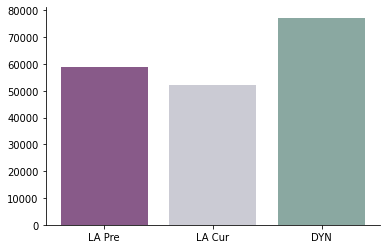

In [9]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_mean_ave, LA_curr_mean_ave, DYN_mean_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])


<BarContainer object of 3 artists>

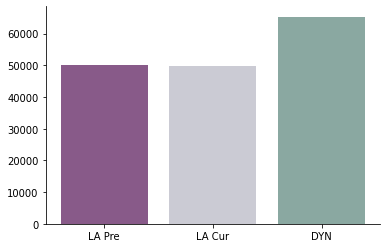

In [10]:
plt.bar(["LA Pre", "LA Cur", "DYN"], [LA_pre_median_ave, LA_curr_median_ave, DYN_median_ave], color=[samplers_color[1], samplers_color[2], samplers_color[0]])

## over all speed up

In [11]:
mean = lambda x, y: np.mean(1 - np.array(x) / np.array(y))
median = lambda x, y: np.median(1 - np.array(x) / np.array(y))

SETTINGS = ["250N_128W", "250N_128W", "500N_128W", "500N_128W", "500N_256W", "500N_256W", "1000N_256W", "1000N_256W"]

def grouped_mean(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    means_x = [np.mean([x[i] for i in s_cat]) for s_cat in s_cats]
    means_y = [np.mean([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return mean(means_x, means_y)

def grouped_median(x, y, s):
    # group by setting
    s_cats = pd.Series(range(len(s))).groupby(s, sort=False).apply(list).tolist()
    # calculate mean per setting
    medians_x = [np.median([x[i] for i in s_cat]) for s_cat in s_cats]
    medians_y = [np.median([y[i] for i in s_cat]) for s_cat in s_cats]
    # calculate mean speed-up across settings
    return median(medians_x, medians_y)

# M1



print("M1")
print("LA Pre vs DYN:", "mean", mean(LA_pre_mean_all, DYN_mean_all), "median", median(LA_pre_mean_all, DYN_mean_all))
print("LA Cur vs DYN:", "mean", mean(LA_curr_mean_all, DYN_mean_all), "median", median(LA_curr_mean_all, DYN_mean_all))

print("M1 grouped")
print("LA Pre vs DYN:", "mean", grouped_mean(LA_pre_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_pre_mean_all, DYN_mean_all, SETTINGS))
print("LA Cur vs DYN:", "mean", grouped_mean(LA_curr_mean_all, DYN_mean_all, SETTINGS), "median", grouped_median(LA_curr_mean_all, DYN_mean_all, SETTINGS))


M1
LA Pre vs DYN: mean 0.11511377579136446 median 0.10012830898596453
LA Cur vs DYN: mean 0.18745262267206664 median 0.15960841182529117
M1 grouped
LA Pre vs DYN: mean 0.1333051098536822 median 0.1606633147704244
LA Cur vs DYN: mean 0.2067526331894777 median 0.22891908474757577


# CI

In [12]:
from pyabc.visualization.credible import compute_quantile, compute_credible_interval
from typing import List, Union

#df_LA, w_LA = history_DLA.get_distribution(m=m, t=history_DLA.max_t)
#df_DYN, w_DYN = history_ORI.get_distribution(m=m, t=history_ORI.max_t)
def get_intervals(history, par_names: List = None, levels: List = [0.5,0.95], t_curr=0):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)
    
    median = np.empty((len(par_names)))
    cis = np.empty((len(par_names),2*len(levels)))
    
    df, w = history.get_distribution(m=0, t=t_curr)
    # normalize weights to be sure
    w /= w.sum()
    
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[i_par] = compute_quantile(vals, w, 0.5)
        # levels
        for i_c, confidence in enumerate(levels):
            lb, ub = compute_credible_interval(
                vals, w, confidence)
            cis[i_par, i_c] = lb
            cis[i_par, -1 - i_c] = ub
    return median, cis

def plot_intervals(median, cis, ax=None, alpha=0.3,
                   par_names: List = None,
                   levels: List = [0.5,0.95],
                   offset: float=0,
                   color: str = None):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)

    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par+offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=6/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color=color)
            ax.vlines(median[i_par],offset+i_par-0.15,offset+i_par+0.15, color="black", alpha=alpha)
    xmin,xmax=ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par+0.5,xmin, xmax, color="black", linewidth=0.5, linestyle="dashed", alpha=0.1)
    ax.set_xlim(xmin,xmax)        

## N=1000/500, W=256

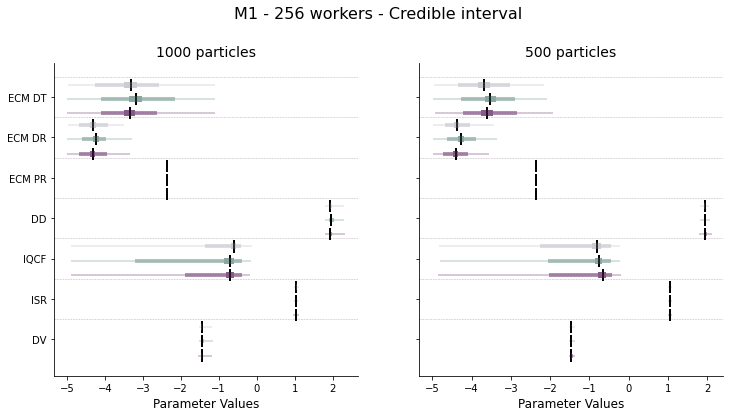

In [13]:
worker_size = 256

gp = "/media/emad/s/HPC/Bonna/lookahead/v3/results/database"

sampler_labels_set1 = ["TumorRes1000_256", "TumorRes_ori1000_256", "TumorRes_old1000_256"]
sampler_labels_set2 = ["TumorRes500_256", "TumorRes_ori500_256", "TumorRes_old500_256"]


population_index = {"TumorRes1000_256_1": 29, "TumorRes1000_256_2": 29,
                    "TumorRes_ori1000_256_1": 29, "TumorRes_ori1000_256_2": 26,
                    "TumorRes_old1000_256_1": 28,"TumorRes_old1000_256_2": 28,
                   "TumorRes500_256_1": 29, "TumorRes500_256_2": 29, 
                    "TumorRes_ori500_256_1": 28, "TumorRes_ori500_256_2": 29,
                    "TumorRes_old500_256_1": 29,"TumorRes_old500_256_2": 28,
}

parameter_names=["log_division_rate",
                "log_initial_spheroid_radius",
                "log_initial_quiescent_cell_fraction",
                 "log_division_depth",
                "log_ecm_production_rate",
           'log_ecm_degradation_rate',
           'log_ecm_division_threshold'
]

names={"log_division_rate": "DV", 
                "log_initial_spheroid_radius": "ISR", 
                "log_initial_quiescent_cell_fraction": "IQCF", 
                "log_division_depth": "DD",
                "log_ecm_production_rate": "ECM PR",
                "log_ecm_degradation_rate": "ECM DR",
                "log_ecm_division_threshold": "ECM DT"
      }


iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []

    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]
        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("1000 particles", fontsize=14)
ax[1].set_title("500 particles", fontsize=14)


fig.suptitle(f"M1 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M1_figures/M1_CI_1000_500px{worker_size}w.pdf", format="pdf", bbox_inches="tight")



## N=500/250, W=128

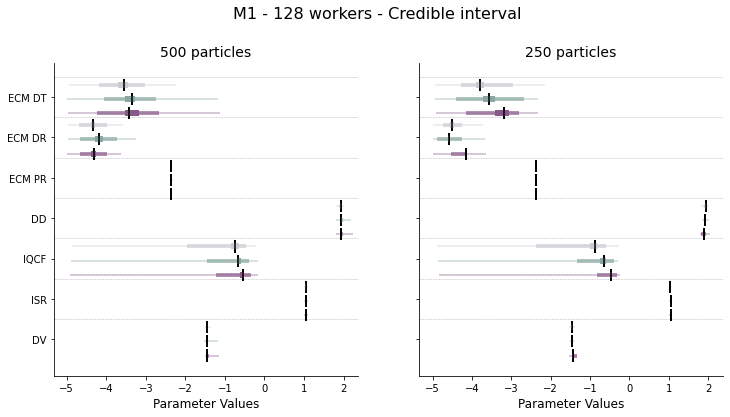

In [14]:
worker_size = 128

gp = "/media/emad/s/HPC/Bonna/lookahead/v3/results/database"

sampler_labels_set1 = ["TumorRes500_128", "TumorRes_ori500_128", "TumorRes_old500_128"]
sampler_labels_set2 = ["TumorRes250_128", "TumorRes_ori250_128", "TumorRes_old250_128"]


population_index = {"TumorRes500_128_1": 29, "TumorRes500_128_2": 29,
                    "TumorRes_ori500_128_1": 29, "TumorRes_ori500_128_2": 27,
                    "TumorRes_old500_128_1": 29,"TumorRes_old500_128_2": 27,
                   "TumorRes250_128_1": 27, "TumorRes250_128_2": 27, 
                    "TumorRes_ori250_128_1": 28, "TumorRes_ori250_128_2": 28,
                    "TumorRes_old250_128_1": 29,"TumorRes_old250_128_2": 27,
}

colors_map_eps = {'TumorRes250_128':samplers_color[2], 'TumorRes500_128':samplers_color[2],
              'TumorRes_ori250_128':samplers_color[0], 'TumorRes_ori500_128':samplers_color[0],
             'TumorRes_old250_128':samplers_color[1], 'TumorRes_old500_128':samplers_color[1]}         


parameter_names=["log_division_rate",
                "log_initial_spheroid_radius",
                "log_initial_quiescent_cell_fraction",
                 "log_division_depth",
                "log_ecm_production_rate",
           'log_ecm_degradation_rate',
           'log_ecm_division_threshold'
]

# names={"log_division_rate": "Division rate", 
#                 "log_initial_spheroid_radius": "Initial spheroid radius", 
#                 "log_initial_quiescent_cell_fraction": "Initial quiescent cell fraction", 
#                 "log_division_depth": "Division depth",
#                 "log_ecm_production_rate": "ECM production rate",
#                 "log_ecm_degradation_rate": "ECM degradation rate",
#                 "log_ecm_division_threshold": "ECM division threshold"
#       }

# names={"log_division_rate": "Division rate", 
#                 "log_initial_spheroid_radius": "Initial spheroid radius", 
#                 "log_initial_quiescent_cell_fraction": "Initial quiescent cell fraction", 
#                 "log_division_depth": "Division depth",
#                 "log_ecm_production_rate": "ECM production rate",
#                 "log_ecm_degradation_rate": "ECM degradation rate",
#                 "log_ecm_division_threshold": "ECM division threshold"
#       }

iters = 1
levels = [0.1,0.5,0.99]
fig, ax = plt.subplots(1,2,figsize=(12,6))
offset = 0.3
for sampler_index, sampler_label in enumerate(sampler_labels_set1):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[0], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[0].set_yticks(range(len(parameter_names)))
        ax[0].set_yticklabels([names[parameter_names[i]] for i in range(len(parameter_names))], rotation=0)
        ax[0].set_xlabel("Parameter Values", fontsize=12)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[0].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[0].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

offset = 0.3
levels = [0.1,0.5,0.99]

for sampler_index, sampler_label in enumerate(sampler_labels_set2):
    times_for_sampler = []
    samples_for_sampler = []
    for ix in range(iters):
        if f"{sampler_label}_{str(ix+1)}" in ["liver_1000_256_ORI_1", "liver_500_256_ORI_1", "liver_500_256_ORI_2"]:
            sampler_db = f"{sampler_label}_{str(ix+1)}_confirmation"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}_confirmation"]
        else:
            sampler_db = f"{sampler_label}_{str(ix+1)}"
            pop_index = population_index[f"{sampler_label}_{str(ix+1)}"]

        h = pyabc.History(
            f"sqlite:///{gp}/{sampler_db}.db", create=False)
        median, cis = get_intervals(h, par_names=parameter_names, levels=levels, t_curr=pop_index-1)
#         median14, cis14 = get_intervals(history714, par_names=parameter_names, levels=levels, t_curr=13)

        plot_intervals(median, cis, par_names=parameter_names, ax=ax[1], levels=levels, offset=offset, color=colors_map_eps[sampler_label], alpha=1)
#         plot_intervals(median14, cis14, par_names=parameter_names, levels=levels, offset=-0.15, color = sim_color14)

        ax[1].set_yticks(range(len(parameter_names)))
        ax[1].set_yticklabels("")
        ax[1].set_xlabel("Parameter Values", fontsize=12)
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)

        for i_c, confidence in reversed(list(enumerate(levels))):
            ax[1].hlines(0,0,0,
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color="black",
                      label=str(int(100*confidence))+"% Quantile")

        ax[1].hlines(0,0,0, linewidth=10, alpha=1)
#         ax.hlines(0,0,0, linewidth=10, alpha=1, color=sim_color, label="7 param L1+Ada.+MAD+SensiLR+Manual - 32 nodes")
        #ax.vlines(0,0,0, color="black", label="Medians")

#         ax[0].legend(loc=1)
        offset = offset-0.35

ax[0].set_title("500 particles", fontsize=14)
ax[1].set_title("250 particles", fontsize=14)


fig.suptitle(f"M1 - {worker_size} workers - Credible interval", fontsize=16)
fig.subplots_adjust(top=0.85)

plt.savefig(f"M1_figures/M1_CI_500_250px{worker_size}w.pdf", format="pdf", bbox_inches="tight")


In [15]:
#specify which run to use
psize=1000
wsize=256
version=1

#read in database as pyabc.history object
gp = "/media/emad/s/HPC/Bonna/lookahead/v3/results/database"

history_DLA_LA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_old"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

history_ORI=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_ori"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

history_DLA_LA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLACurr.csv")
history_DLA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLAPre.csv")
history_ORI.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopOri.csv")

In [16]:
#set limits, parameter names, axis names
limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))


parameter_names=["log_division_depth",
                "log_division_rate",
                "log_ecm_degradation_rate",
                "log_ecm_division_threshold",
                "log_ecm_production_rate",
                "log_initial_quiescent_cell_fraction",
                "log_initial_spheroid_radius"]

names={"log_division_depth":"Division Depth",
       "log_division_rate":"Division Rate",
       "log_ecm_degradation_rate":"ECM Degradation Rate",
       "log_ecm_division_threshold":"ECM Division Threshold",
       "log_ecm_production_rate":"ECM Production Rate",
       "log_initial_quiescent_cell_fraction":"Init. quiescent Cell Frac.",
       "log_initial_spheroid_radius":"Init. Spheroid Radius"
      }


/tmp/ipykernel_4239/3335310267.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


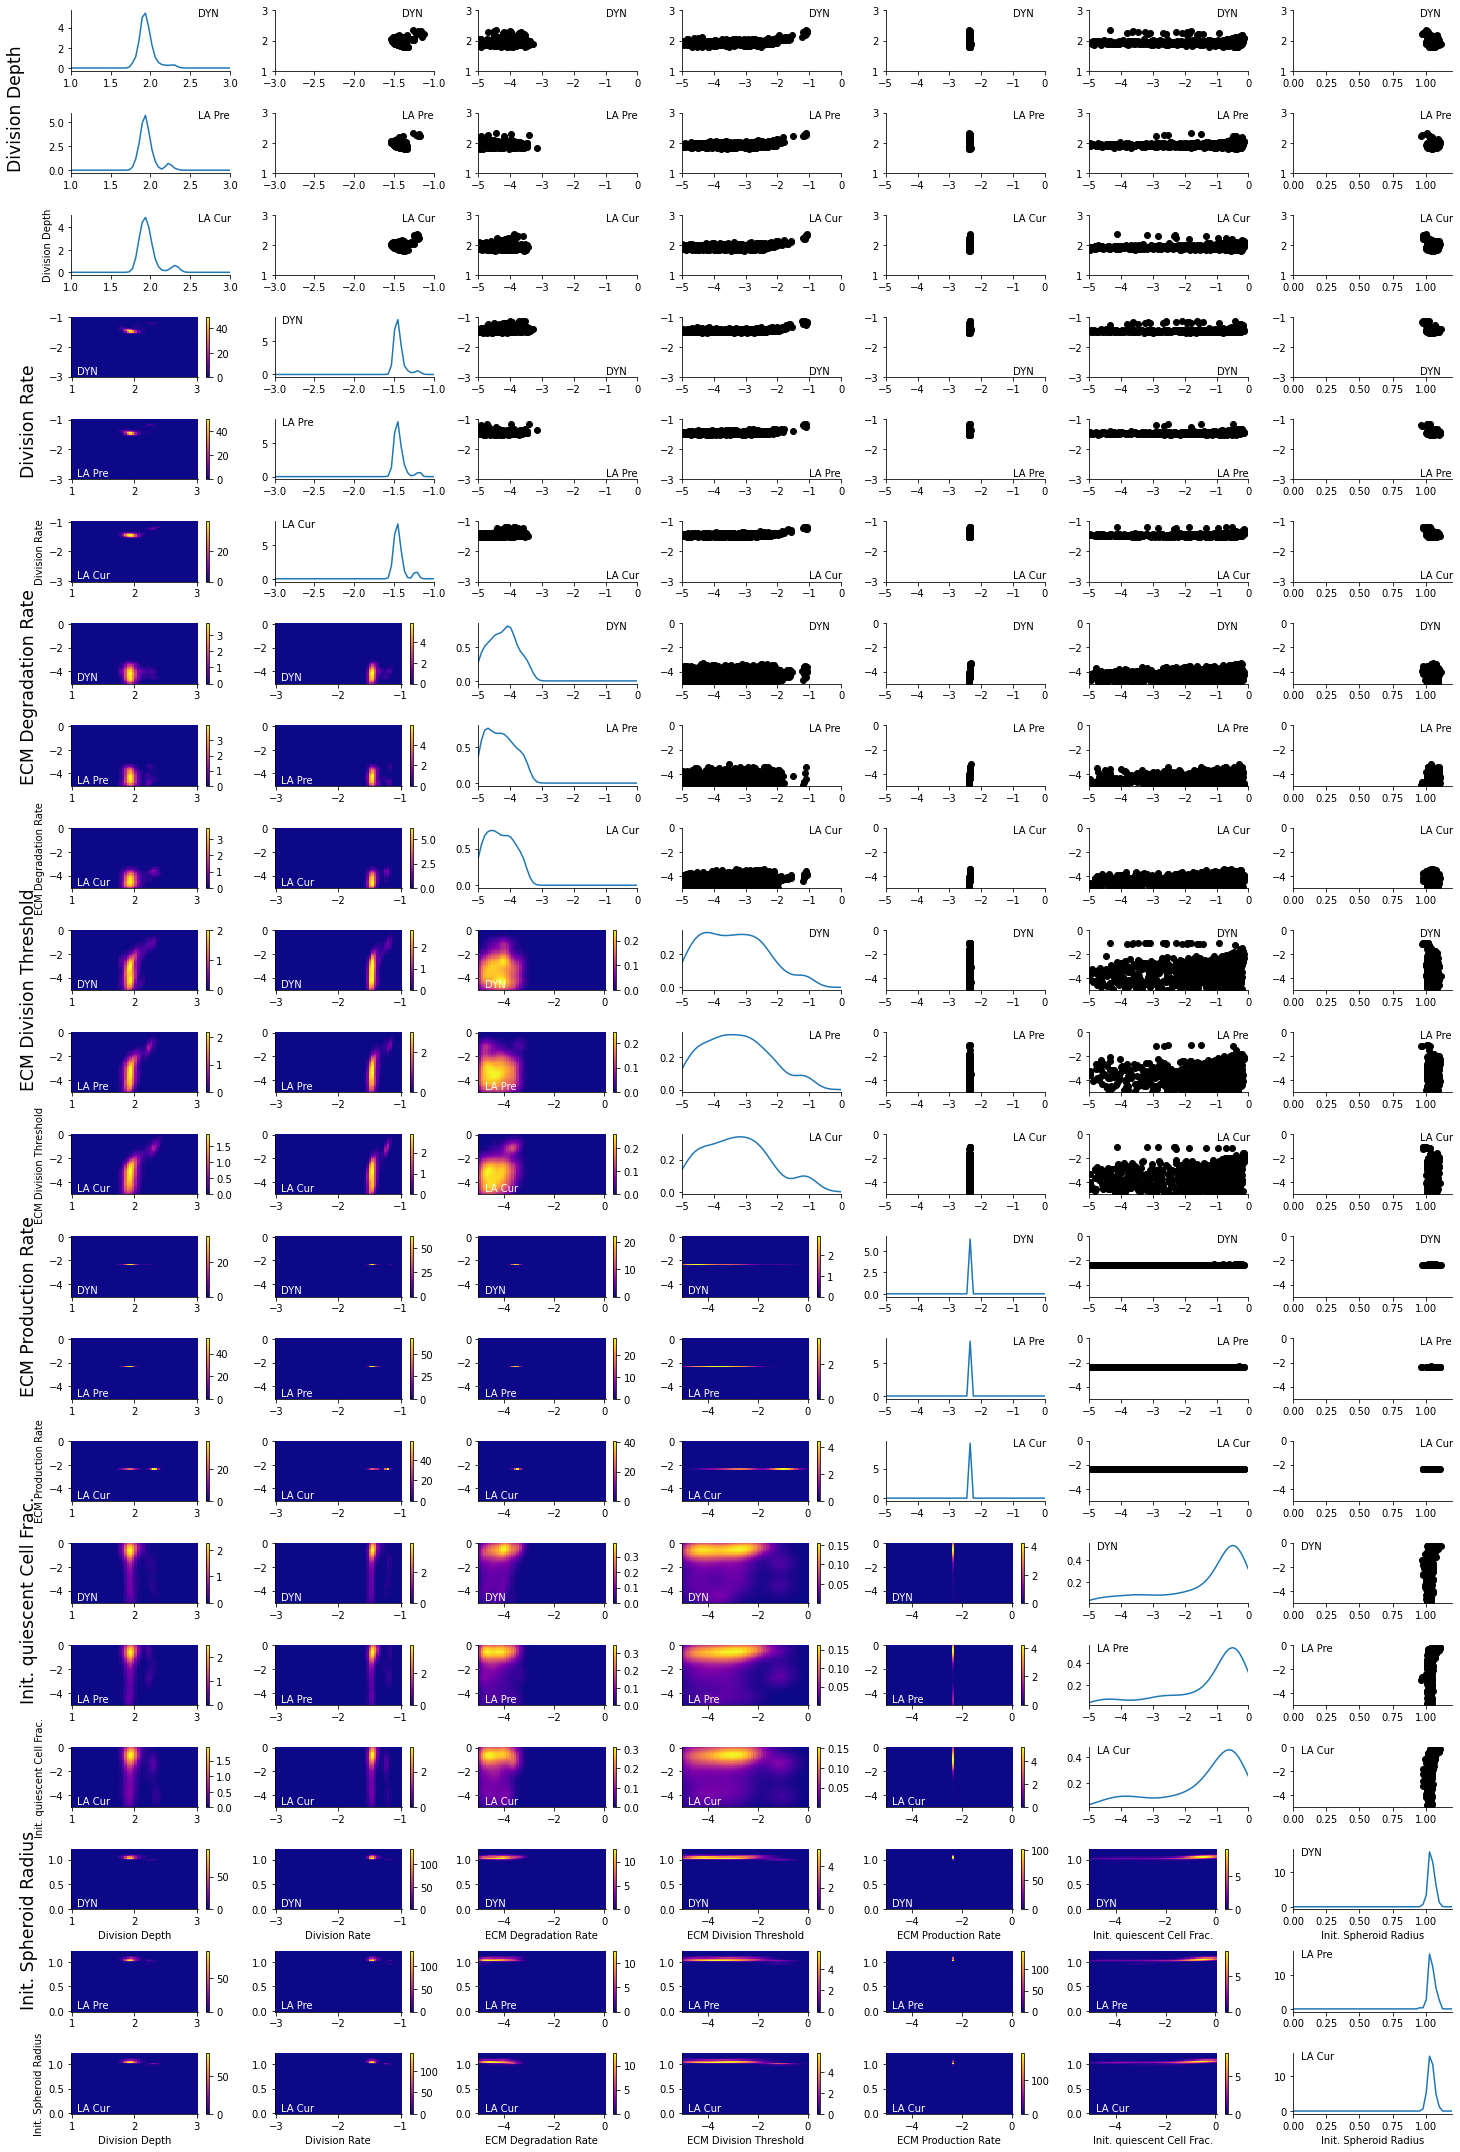

In [17]:
# Comparision of both posteriors in one plot (Figure 18)

fig, axes = plt.subplots(21,7,figsize=(20,30))

axes_DYN = axes[[3*i for i in range(7)],:]
axes_LA = axes[[3*i+1 for i in range(7)],:]
axes_LA_Curr = axes[[3*i+2 for i in range(7)],:]

df, w = history_DLA.get_distribution(m=0, t=history_DLA.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, arr_ax=axes_LA, names = names);

df, w = history_DLA_LA.get_distribution(m=0, t=history_DLA.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, arr_ax=axes_LA_Curr, names = names);

df, w = history_ORI.get_distribution(m=0, t=history_DLA.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, arr_ax=axes_DYN, names = names);


#everything in the next lines is just axis labelings and formatting

for i in range(7):
    axes[-2,i].set_xlabel(None)
    
for i in range(7):
    axes[3*i,0].set_ylabel(None)
    axes[3*i+1,0].set_ylabel(None)

    ax = axes[3*i+1,0]
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    ax.text(xmin-0.4*(xmax-xmin),ymin+0.1*(ymax-ymin),
            names[parameter_names[i]],
            rotation="vertical", size="xx-large")

    
    ax = axes[3*i,1]

for i in range(7):
    for j in range(7):
        if j>i:
            color='white'
            x_off = 0.05
            y_off = 0.05

        else:
            color='black'
            if j==1:
                if i==1:
                    x_off=0.05
                    y_off=0.9
                else:
                    x_off=0.8
                    y_off=0.05
            if j==0 or j==2 or j==3 or j==4:
                x_off=0.8
                y_off=0.9
            if j==5 or j==6:
                x_off=0.05
                y_off=0.9
        ax = axes[3*j,i]
        xmin,xmax=ax.get_xlim()
        ymin,ymax=ax.get_ylim()
        ax.text((1-x_off)*xmin+x_off*xmax,(1-y_off)*ymin+y_off*ymax, "DYN", color=color)

        ax = axes[3*j+1,i]
        xmin,xmax=ax.get_xlim()
        ymin,ymax=ax.get_ylim()
        ax.text((1-x_off)*xmin+x_off*xmax,(1-y_off)*ymin+y_off*ymax, "LA Pre", color=color)

        ax = axes[3*j+2,i]
        xmin,xmax=ax.get_xlim()
        ymin,ymax=ax.get_ylim()
        ax.text((1-x_off)*xmin+x_off*xmax,(1-y_off)*ymin+y_off*ymax, "LA Cur", color=color)


fig.tight_layout()

plt.savefig(f"M1_figures/M1_Posteriors{str(psize)}V{str(version)}.pdf")

In [18]:
xticks = [0]
i=0
max_gen=max(len(history_DLA.get_all_populations()), len(history_ORI.get_all_populations()))-1

while i < max_gen-3:
    i=i+8
    xticks.append(i)


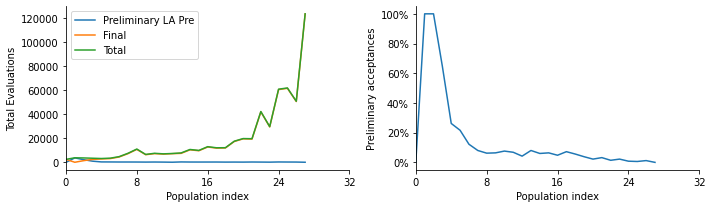

In [19]:
#Read .csv logfile of the run to extract the LA-mode statistics 
# Plot fraction of preliminary acceptances (Figure 19)
version=1
wsize=256
psize=1000

stat_path = Path(os.path.abspath(gp)).parent.absolute()
stat_df = pd.read_csv(str(stat_path)+"/stat/TumorStats_OLD"+str(psize)+"_"+str(wsize)+"_"+str(version)+".csv")[1:]

fig, axes = plt.subplots(1,2, figsize=(10,3))


ax = axes[0]

ax.plot(stat_df['t'],stat_df['n_lookahead'], label="Preliminary LA Pre")
ax.plot(stat_df['t'],stat_df['n_evaluated']-stat_df['n_lookahead'], label="Final")
ax.plot(stat_df['t'],stat_df['n_evaluated'], label="Total")

ax.set_ylabel("Total Evaluations")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()


ax = axes[1]

n_lookahead_particles=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_lookahead_particles[i]=min(500, stat_df['n_lookahead_accepted'][i+1])/500
    
ax.plot(stat_df['t'], n_lookahead_particles)

ax.set_ylabel("Preliminary acceptances")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)
"""
ax = axes[2]

n_total_acceptances=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_total_acceptances[i]=max(stat_df['n_accepted'][i+1], stat_df['n_lookahead_accepted'][i+1])

ax.plot(stat_df['t'], stat_df['n_lookahead_accepted']/stat_df['n_lookahead'], label='look_ahead')
ax.plot(stat_df['t'], n_total_acceptances/stat_df['n_evaluated'], label='total')


ax.title.set_text("Acceptance rates")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.legend()
"""

fig.tight_layout()
plt.show()

fig.savefig(f"M1_figures/AcceptancesN"+str(psize)+"V"+str(version)+".pdf")

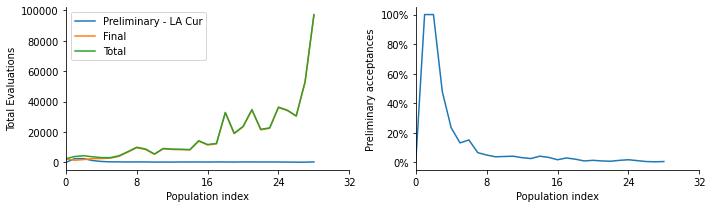

In [20]:
#Read .csv logfile of the run to extract the LA-mode statistics 
# Plot fraction of preliminary acceptances (Figure 19)
stat_path = Path(os.path.abspath(gp)).parent.absolute()
stat_df = pd.read_csv(str(stat_path)+"/TumorStats"+str(psize)+"_"+str(wsize)+"_"+str(version)+".csv")[1:]

fig, axes = plt.subplots(1,2, figsize=(10,3))


ax = axes[0]

ax.plot(stat_df['t'],stat_df['n_lookahead'], label="Preliminary - LA Cur")
ax.plot(stat_df['t'],stat_df['n_evaluated']-stat_df['n_lookahead'], label="Final")
ax.plot(stat_df['t'],stat_df['n_evaluated'], label="Total")

ax.set_ylabel("Total Evaluations")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()


ax = axes[1]

n_lookahead_particles=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_lookahead_particles[i]=min(500, stat_df['n_lookahead_accepted'][i+1])/500
    
ax.plot(stat_df['t'], n_lookahead_particles)

ax.set_ylabel("Preliminary acceptances")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.set_xlabel("Population index")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=10)
"""
ax = axes[2]

n_total_acceptances=np.zeros(len(stat_df))
for i in range(len(stat_df)):
    n_total_acceptances[i]=max(stat_df['n_accepted'][i+1], stat_df['n_lookahead_accepted'][i+1])

ax.plot(stat_df['t'], stat_df['n_lookahead_accepted']/stat_df['n_lookahead'], label='look_ahead')
ax.plot(stat_df['t'], n_total_acceptances/stat_df['n_evaluated'], label='total')


ax.title.set_text("Acceptance rates")
ax.set_xlim(xmin=0,xmax=len(stat_df))
ax.legend()
"""

fig.tight_layout()
plt.show()

fig.savefig(f"M1_figures/AcceptancesN{str(psize)}V{str(version)}_LA.pdf")

## Epsilon vs. time

In [21]:
population_index = {"TumorRes1000_256_1": 29, "TumorRes1000_256_2": 29,
                    "TumorRes_ori1000_256_1": 29, "TumorRes_ori1000_256_2": 26,
                    "TumorRes_old1000_256_1": 28,"TumorRes_old1000_256_2": 28,
                   "TumorRes500_256_1": 29, "TumorRes500_256_2": 29, 
                    "TumorRes_ori500_256_1": 28, "TumorRes_ori500_256_2": 29,
                    "TumorRes_old500_256_1": 29,"TumorRes_old500_256_2": 28,
                    "TumorRes500_128_1": 29, "TumorRes500_128_2": 29,
                    "TumorRes_ori500_128_1": 29, "TumorRes_ori500_128_2": 27,
                    "TumorRes_old500_128_1": 29,"TumorRes_old500_128_2": 27,
                   "TumorRes250_128_1": 27, "TumorRes250_128_2": 27, 
                    "TumorRes_ori250_128_1": 28, "TumorRes_ori250_128_2": 28,
                    "TumorRes_old250_128_1": 29,"TumorRes_old250_128_2": 27,  
}


In [22]:
#specify which run to use
psize=1000
wsize=256
version=1

#read in database as pyabc.history object

history_DLA_LA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_old"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

history_ORI=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_ori"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

#read in database as pyabc.history object

# history_DLA_LA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLACurr.csv")
# history_DLA.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopLAPre.csv")
# history_ORI.get_all_populations().to_csv(gp+"/Tumor"+str(psize)+"AllPopOri.csv")
#Extract runtime information

DLADF = history_DLA.get_all_populations()
DLADF = DLADF.truncate(after=population_index[f"TumorRes_old{psize}_{wsize}_{version}"])
starttime = DLADF["population_end_time"][0]

new_col=[]
for i in range(0,len(DLADF)):
    new_col.append((DLADF["population_end_time"][i]-DLADF["population_end_time"][0]).total_seconds())

DLADF.insert(2, "time_passed_s", new_col, True)


ORIDF = history_ORI.get_all_populations()
ORIDF = ORIDF.truncate(after=population_index[f"TumorRes_ori{psize}_{wsize}_{version}"])

starttime = ORIDF["population_end_time"][0]

new_col=[]
for i in range(0,len(ORIDF)):
    new_col.append((ORIDF["population_end_time"][i]-ORIDF["population_end_time"][0]).total_seconds())

ORIDF.insert(2, "time_passed_s", new_col, True)


LA_curr = history_DLA_LA.get_all_populations()
LA_curr = LA_curr.truncate(after=population_index[f"TumorRes{psize}_{wsize}_{version}"])

starttime = LA_curr["population_end_time"][0]

new_col=[]
for i in range(0,len(LA_curr)):
    new_col.append((LA_curr["population_end_time"][i]-LA_curr["population_end_time"][0]).total_seconds())

LA_curr.insert(2, "time_passed_s", new_col, True)


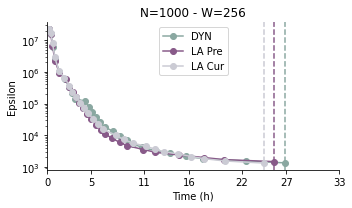

In [23]:

#Plot Epsilon development over time (Figure 20B & 22)
fig, axes = plt.subplots(1,1, figsize=(5,3))

ax = axes
ax.plot(ORIDF["time_passed_s"], ORIDF["epsilon"], label = "DYN", marker="o", color=samplers_color[0])
ax.plot(DLADF["time_passed_s"], DLADF["epsilon"], label = "LA Pre", marker="o", color=samplers_color[1])
ax.plot(LA_curr["time_passed_s"], LA_curr["epsilon"], label = "LA Cur", marker="o", color=samplers_color[2])

ax.set_yscale("log")
ax.set_ylabel("Epsilon")
ax.set_xlabel("Time (h)")
ax.axvline(ORIDF["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[0])
ax.axvline(DLADF["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[1])
ax.axvline(LA_curr["time_passed_s"].iloc[-1], linestyle='dashed', color=samplers_color[2])
ax.set_xlim(xmin=0)
xticklabels=[int(a/3600) for a in (ax.get_xticks())]
ax.set_xticks([a*3600 for a in xticklabels])
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f"N={str(psize)} - W={str(wsize)}")
ax.legend()

fig.tight_layout()
plt.savefig(f"M1_figures/EpsilonOverTimeN{str(psize)}W{str(wsize)}V{str(version)}.pdf")


## Fitting plot of Simulation to data

In [24]:
data_path = "/home/emad/Insync/blackhand.3@gmail.com/Google_Drive/Bonn" \
            "/Documents/Morpheus/Tumor_model/obs_data"
delta = 2
start = 1
prof_ECM_tpoints = np.arange(1, 1001).tolist()
radius_tpoints = np.arange(0, 20).tolist()


In [25]:
history_DLA.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2022-12-16 06:59:29.147446,1000,inf,1
1,0,2022-12-16 07:02:33.221032,2502,2.245693e+07,1000
2,1,2022-12-16 07:04:10.361816,3800,2.243523e+07,1000
3,2,2022-12-16 07:07:29.327032,3681,2.241116e+07,1000
4,3,2022-12-16 07:13:26.769468,3436,2.204645e+07,1000
5,4,2022-12-16 07:24:08.326988,3214,1.556316e+07,1000
6,5,2022-12-16 07:36:16.502083,3489,6.629088e+06,1000
7,6,2022-12-16 07:54:07.568894,4758,2.166857e+06,1000
8,7,2022-12-16 08:23:30.226544,7538,9.121286e+05,1000
9,8,2022-12-16 09:04:53.473128,11068,6.080928e+05,1000


In [26]:
from fitmulticell.util import tsv_to_df
# import seaborn as sns
# sns.set()

def read_measurment_data(loc, delta=10, start=1):
    
    obs_data = {}
    radius = tsv_to_df(data_path, "radius_19_err.csv")
    prolif = tsv_to_df(data_path, "prolif_ratio_err.csv")
    ecm = tsv_to_df(data_path, "ecm_err.csv")
    obs_data["growth_curve"] = np.array(radius.iloc[:, 1])
    obs_data["proliferation_profile"] = np.array(prolif.iloc[:, 1])[start::delta]
    obs_data["extra_cellular_matrix_profile"] = np.array(ecm.iloc[:, 1])[start::delta]

    obs_data["growth_curve_err"] = np.array(radius.iloc[:, 2])
    obs_data["proliferation_profile_err"] = np.array(prolif.iloc[:, 2])[start::delta]
    obs_data["extra_cellular_matrix_profile_err"] = np.array(ecm.iloc[:, 2])[start::delta]
    return obs_data


def read_simulated_data(db_path, population_index = None):
    history = pyabc.History("sqlite:///" + db_path)
    if not population_index:
        population = history.get_population()
    else:
        population = history.get_population(population_index)

    return population


def plot_data(data, axes, pcy, ry, label="data", legend_flag=True, ylim=None, color="k"):
    # rows = len(data.keys())
    # fig, axes = plt.subplots(rows)
    index = 0
    for key, val in data.items():
        if key.find("err") != -1:
            continue
#         axes[index].set_title(key)
        if key == "growth_curve":
            x = ry
        else:
            x = np.arange(1, len(val)+1).tolist()
        axes[index].plot(x, val, linestyle='', marker="x", label="Data", color=color)  ### what you want you can plot
#         axes[index].errorbar(x, val, yerr = data[key+"_err"]*2, label = label, fmt ='o', markersize=4, color=color)
        index = index +1
    if legend_flag:
        axes[0].legend()
    if ylim is not None:
        axes[2].set_ylim(ylim)
    return axes


def plot_simulation(population, pcy, ry, color_simulation=None, label=None, alpha=0.1, n=np.inf):
    rows = len(simulation.particles[1].sum_stat.keys())
    fig, axes = plt.subplots(rows,figsize=(8,6))
    color_data = ["b", "b", "b"]
    if color_simulation==None:
        color_simulation = ["darkgoldenrod", "darkgreen", "darkred"]
    xlabels = ["Time [d]", "Distance to rim [uM]", "Distance to rim [uM]"]
    ylabels = ["Radius [uM]", "Proliferating cells [%]", "ECM intensity [au]"]
    ylimits = [[0, 380], [0, 0.5], [0, 0.1]]
    counter=0
    for particle in population.particles:
        counter = counter + 1
        if counter > n:
            break
        curr_particle = particle.sum_stat
        for i, (key, val) in enumerate(curr_particle.items()):
            axes[i].set_title(key)
            axes[i].set_xlabel(xlabels[i])
            axes[i].set_ylabel(ylabels[i])
            if key == "growth_curve":
                x = ry
            else:
                x = pcy
            if label != None and i==1:
                axes[i].plot(x, val,color=color_simulation[i], alpha=alpha, label=label)  ### what you want you can plot
            else:
                axes[i].plot(x, val,color=color_simulation[i], alpha=alpha)  ### what you want you can plot
            # axes.set_xlim([xmin, xmax])
    plt.legend()
    return axes


def plot_simulation_interval(population, ry, pcy, color_simulation=None, mean_flag=True, color_mean = "C1",
                             legend_flag=True,
                             label="sim", axes=[], fig=None, alpha=0.1, std_degree=1, fig_size=(8,6),
                             mean_label="mean"):
    size_sum_stat = len(population.particles[0].sum_stat)
    title_sum_stat = list(population.particles[0].sum_stat.keys())
    # create empty dit
    all_particles = {}
    for key, val in population.particles[0].sum_stat.items():
        all_particles[key] = []
    if len(axes) == 0:
        rows = size_sum_stat
        fig, axes = plt.subplots(rows,figsize=fig_size)
    color_data = ["b", "b", "b"]
    if color_simulation==None:
        color_simulation = ["darkgoldenrod", "darkgreen", "darkred"]
    xlabels = ["Time [d]", "Distance to rim [uM]", "Distance to rim [uM]"]
    ylabels = ["Radius [uM]", "Proliferating cells [%]", "ECM intensity [au]"]
    ylimits = [[0, 380], [0, 0.5], [0, 0.1]]
    particles = population.particles.__len__()
    for j in range(particles):
        curr_particle = population.particles[j].sum_stat
        for key, val in curr_particle.items():
            # curr_data = curr_particle.values
            all_particles[key].append(val)

    for i, key in zip(range(size_sum_stat), title_sum_stat):
        if key == "growth_curve":
            x = ry
        else:
            x = pcy
#         axes[i].set_title(key)
        axes[i].set_xlabel(xlabels[i])
        axes[i].set_ylabel(ylabels[i])
        means = np.mean(all_particles[key], axis=0)
        stds = np.std(all_particles[key], axis=0)
        stds = stds * std_degree
        axes[i].fill_between(x, means-stds, means+stds,alpha=alpha, color=color_simulation, label=label)
        if mean_flag:
            axes[i].plot(x, means, color=color_mean, label=mean_label)

        # axes.set_xlim([xmin, xmax])
#         plt.legend()
    if legend_flag:
        plt.legend()
    fig.tight_layout()  # Or equivalently,  "plt.tight_layout()"

    return axes, fig

from pyabc.visualization.credible import compute_quantile, compute_credible_interval
from typing import List, Union

#df_LA, w_LA = history_DLA.get_distribution(m=m, t=history_DLA.max_t)
#df_DYN, w_DYN = history_ORI.get_distribution(m=m, t=history_ORI.max_t)
def get_intervals(history, par_names: List = None, levels: List = [0.5,0.95], t_curr=0):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)
    
    median = np.empty((len(par_names)))
    cis = np.empty((len(par_names),2*len(levels)))
    
    df, w = history.get_distribution(m=0, t=t_curr)
    # normalize weights to be sure
    w /= w.sum()
    
    for i_par, par in enumerate(par_names):
        # as numpy array
        vals = np.array(df[par])
        # median
        median[i_par] = compute_quantile(vals, w, 0.5)
        # levels
        for i_c, confidence in enumerate(levels):
            lb, ub = compute_credible_interval(
                vals, w, confidence)
            cis[i_par, i_c] = lb
            cis[i_par, -1 - i_c] = ub
    return median, cis

def plot_intervals(median, cis,
                   par_names: List = None,
                   levels: List = [0.5,0.95],
                   offset: float=0,
                   color: str = None):
    if par_names is None:
        # extract all parameter names
        df, _ = history.get_distribution(m=0)
        par_names = list(df.columns.values)

    for i_par, par in enumerate(par_names):
        for i_c, confidence in reversed(list(enumerate(levels))):
            ax.hlines(i_par+offset,
                      cis[i_par, i_c],
                      cis[i_par, -1 - i_c],
                      linewidth=10/len(levels)*(len(levels)-i_c),
                      alpha = 1/len(levels)*(len(levels)-i_c),
                      color=color)
            ax.vlines(median[i_par],offset+i_par-0.2,offset+i_par+0.2, color="black")
    xmin,xmax=ax.get_xlim()
    for i_par, par in enumerate(par_names):
        ax.hlines(i_par+0.5,xmin, xmax, color="black", linewidth=1, linestyle="dashed", alpha=0.3)
    ax.set_xlim(xmin,xmax)        
    
    
    
def computee_quantile(history,population, t, confidence=0.95):
#     df, w = history.get_distribution(m=0, t=t)
#     # normalize weights to be sure
#     w /= w.sum()
    mean_all = {}
    lb_all = {}
    ub_all = {}
    simulation_data = read_simulated_data(population, t)
    for sumstat in list(simulation_data.particles[1].sum_stat.keys()):
        susmstat_m = []
        susmstat_lb = []
        susmstat_ub = []
        sumstat_len = len(simulation_data.particles[1].sum_stat[sumstat])
        combine_list = []
        # collect all list for specific sumstat
        for i in range(sumstat_len):
            sublist = list(simulation_data.particles[i].sum_stat[sumstat])
            combine_list.append(sublist)
        for j in range(sumstat_len):
            elemnts = [item[j] for item in combine_list]
            elemnts = np.array(elemnts)

            susmstat_m.append(weighted_quantile(elemnts, alpha=0.50))
            lb, ub = computee_credible_interval(elemnts, confidence=confidence)
            susmstat_lb.append(lb)
            susmstat_ub.append(ub)
        mean_all[sumstat] = susmstat_m
        lb_all[sumstat] = susmstat_lb
        ub_all[sumstat] = susmstat_ub

    return mean_all, lb_all, ub_all

def computee_credible_interval(vals, confidence: float = 0.95):
    """
    Compute credible interval to confidence level `confidence` for points
    `vals` associated to weights `weights`.
    Returns
    -------
    lb, ub: tuple of float
        Lower and upper bound of the credible interval.
    """
    if confidence <= 0.0 or confidence >= 1.0:
        raise ValueError(
            f"Confidence {confidence} must be in the interval (0.0, 1.0)."
        )
    alpha_lb = 0.5 * (1.0 - confidence)
    alpha_ub = confidence + alpha_lb
    lb = weighted_quantile(vals, alpha=alpha_lb)
    ub = weighted_quantile(vals, alpha=alpha_ub)
    return lb, ub


def plot_simulation_interval_quantile(mean, lb, ub, ry, pcy, color_simulation=None, mean_flag=True, color_mean = "C1",
                             legend_flag=True, title=None,
                             label="sim", axes=[], fig=None, alpha=0.1, fig_size=(8,6),
                             mean_label="mean", label_size=8, label_flag=True):
    size_sum_stat = len(mean)
    title_sum_stat = list(mean.keys())
    # create empty dit
    if len(axes) == 0:
        rows = size_sum_stat
        fig, axes = plt.subplots(rows,figsize=fig_size)
    color_data = ["b", "b", "b"]
    if color_simulation==None:
        color_simulation = ["darkgoldenrod", "darkgreen", "darkred"]
    xlabels = ["Time [d]", "Distance to rim [uM]", "Distance to rim [uM]"]
    ylabels = ["Radius [uM]", "Proliferating cells [%]", "ECM intensity [au]"]
    ylimits = [[0, 380], [0, 0.5], [0, 0.1]]
    for i, key in zip(range(size_sum_stat), title_sum_stat):
        if key == "growth_curve":
            x = ry
        else:
            x = pcy
#         axes[i].set_title(key)
        if label_flag:
            if i == 2:
                axes[i].set_ylabel(ylabels[i], fontsize=label_size)

            elif i == 0:
                axes[i].set_ylabel(ylabels[i], fontsize=label_size, labelpad=20)
            else:
                axes[i].set_ylabel(ylabels[i], fontsize=label_size, labelpad=21)

        axes[i].set_xlabel(xlabels[i], fontsize=label_size)
        axes[i].fill_between(x, lb[key], ub[key],alpha=alpha, color=color_simulation, label=label)
        if mean_flag:
            axes[i].plot(x, mean[key], color=color_mean, label=mean_label)
        axes[i].xaxis.set_tick_params(labelsize=label_size)
        axes[i].yaxis.set_tick_params(labelsize=label_size)


        # axes.set_xlim([xmin, xmax])
#         plt.legend()
    if legend_flag:
        plt.legend()
    fig.tight_layout()  # Or equivalently,  "plt.tight_layout()"
    if title is not None:
        fig.suptitle(title)
    return axes, fig



In [27]:
sim_color = "C1"
obs_color = "C0"
colors=[sim_color, obs_color]
label = ["adaptive + manual", "adaptive"]
psize=1000
wsize=256
version=1

history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_ori"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
generic_path_history_DLA = str(os.path.join(gp, "TumorRes_ori"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

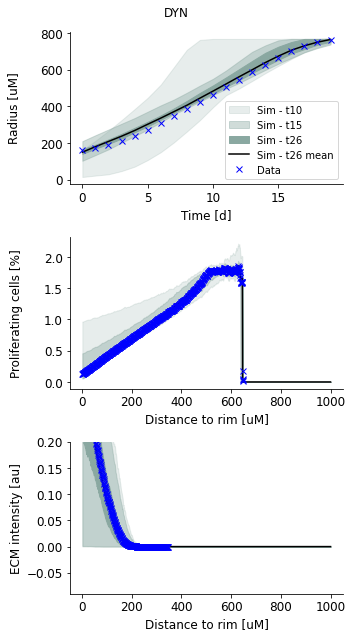

In [28]:
data_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + "/Data/Model_M1/obs_data"

CI_size = (7.5,7.5)
fit_size = (5,9)
color_simulation_final = ["C1", "C1", "C1", "C1"]
color_simulation_final = samplers_color[0]
color_mean_ = "k"
color_simulation_first = ["wheat", "lightgreen", "lightcoral"]
font_size = 12
quan = 0.95


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 10, quan)
# print("mean:", mean)
# print("lb:", lb)
# print("ub:", ub)
axes1, fig1 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t10", alpha=0.20, color_simulation=color_simulation_final,
                                  mean_flag=False,legend_flag=False, fig_size=fit_size, label_size=font_size,
                                               title="DYN")


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 15, quan)
axes2, fig2 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t15", alpha=0.40, color_simulation=color_simulation_final,
                                    axes=axes1, fig=fig1, 
                                  mean_flag=False,legend_flag=False, label_size=font_size)


# mean, lb, ub = computee_quantile(history15LR_cont, generic_path15LR_cont, 30, quan)
# axes3, fig3 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
#                                 label="Sim - t1", alpha=0.50, color_simulation=color_simulation_final[2],
#                                     axes=axes2, fig=fig2, 
#                                   mean_flag=False,legend_flag=False)


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 26, quan)
axes4, fig4 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t26", alpha=1, color_simulation=color_simulation_final,
                                    axes=axes2, fig=fig2, mean_flag=True, color_mean=color_mean_,
                                                mean_label="Sim - t26 mean", label_size=font_size, legend_flag=False)

ylim=[-0.09,0.20]
data_mean = tumor2d.load_default()[1]  # (raw, mean, var)

axes5 =plot_data(data_mean, axes=axes4, pcy=prof_ECM_tpoints, ry=radius_tpoints, label=" Obs " u"\u00B1" " 2 std", ylim=ylim, color='blue')
# plt.legend(loc=2, fontsize=12)

plt.tight_layout()
# fig4.suptitle("LA Pre")
plt.savefig("M1_figures/M1_fit_DYN.pdf", format="pdf")


In [29]:
sim_color = "C1"
obs_color = "C0"
colors=[sim_color, obs_color]
label = ["adaptive + manual", "adaptive"]
psize=1000
wsize=256
version=1

history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes_old"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
generic_path_history_DLA = str(os.path.join(gp, "TumorRes_old"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

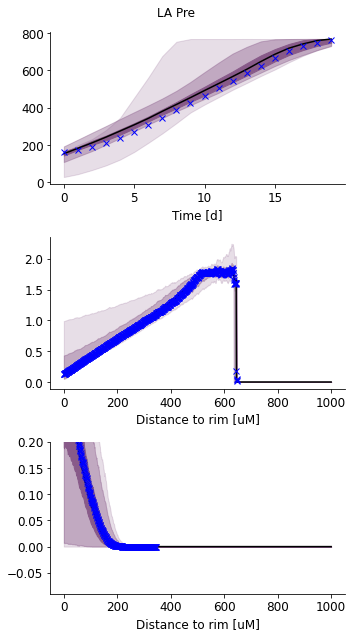

In [30]:

CI_size = (7.5,7.5)
fit_size = (5,9)
color_simulation_final = ["C1", "C1", "C1", "C1"]
color_simulation_final = samplers_color[1]
color_mean_ = "k"
color_simulation_first = ["wheat", "lightgreen", "lightcoral"]
font_size = 12
quan = 0.95


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 10, quan)
# print("mean:", mean)
# print("lb:", lb)
# print("ub:", ub)
axes1, fig1 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t10", alpha=0.20, color_simulation=color_simulation_final,
                                  mean_flag=False,legend_flag=False, fig_size=fit_size, label_size=font_size,
                                               title="LA Pre", label_flag=False)


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 15, quan)
axes2, fig2 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t15", alpha=0.40, color_simulation=color_simulation_final,
                                    axes=axes1, fig=fig1, label_flag=False,
                                  mean_flag=False,legend_flag=False, label_size=font_size)


# mean, lb, ub = computee_quantile(history15LR_cont, generic_path15LR_cont, 30, quan)
# axes3, fig3 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
#                                 label="Sim - t1", alpha=0.50, color_simulation=color_simulation_final[2],
#                                     axes=axes2, fig=fig2, 
#                                   mean_flag=False,legend_flag=False)


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 26, quan)
axes4, fig4 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t26", alpha=1, color_simulation=color_simulation_final,
                                    axes=axes2, fig=fig2, mean_flag=True, legend_flag=False, color_mean=color_mean_,
                                                mean_label="Sim - t26 mean", label_size=font_size, label_flag=False)

ylim=[-0.09,0.20]
data_mean = tumor2d.load_default()[1]  # (raw, mean, var)

axes5 =plot_data(data_mean, axes=axes4, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                 label=" Obs " u"\u00B1" " 2 std", ylim=ylim, color='blue', legend_flag=False)
# plt.legend(loc=2, fontsize=12)

plt.tight_layout()
# fig4.suptitle("LA Pre")
plt.savefig("M1_figures/M1_fit_LA_Pre.pdf", format="pdf")


In [31]:
sim_color = "C1"
obs_color = "C0"
colors=[sim_color, obs_color]
label = ["adaptive + manual", "adaptive"]
psize=1000
wsize=256
version=1

history_DLA=pyabc.History("sqlite:///" +
                          os.path.join(gp,
                                       "TumorRes"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))
generic_path_history_DLA = str(os.path.join(gp, "TumorRes"+str(psize)+"_"+str(wsize)+"_"+str(version)+".db"))

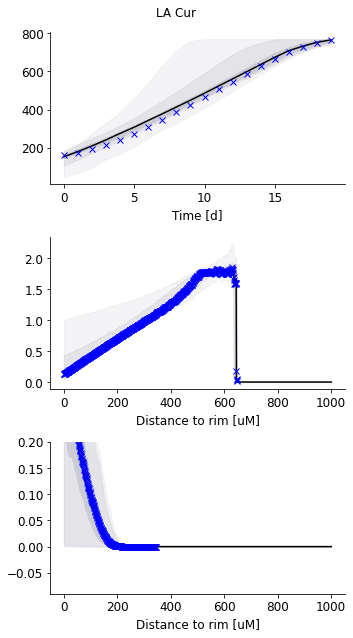

In [32]:

CI_size = (7.5,7.5)
fit_size = (5,9)
color_simulation_final = ["C1", "C1", "C1", "C1"]
color_simulation_final = samplers_color[2]
color_mean_ = "k"
color_simulation_first = ["wheat", "lightgreen", "lightcoral"]
font_size = 12
quan = 0.95


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 10, quan)
# print("mean:", mean)
# print("lb:", lb)
# print("ub:", ub)
axes1, fig1 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t10", alpha=0.20, color_simulation=color_simulation_final,
                                  mean_flag=False,legend_flag=False, fig_size=fit_size, label_size=font_size,
                                               title="LA Cur", label_flag=False)


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 15, quan)
axes2, fig2 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t15", alpha=0.40, color_simulation=color_simulation_final,
                                    axes=axes1, fig=fig1, label_flag=False,
                                  mean_flag=False,legend_flag=False, label_size=font_size)


# mean, lb, ub = computee_quantile(history15LR_cont, generic_path15LR_cont, 30, quan)
# axes3, fig3 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
#                                 label="Sim - t1", alpha=0.50, color_simulation=color_simulation_final[2],
#                                     axes=axes2, fig=fig2, 
#                                   mean_flag=False,legend_flag=False)


mean, lb, ub = computee_quantile(history_DLA, generic_path_history_DLA, 26, quan)
axes4, fig4 = plot_simulation_interval_quantile(mean, lb, ub, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                                label="Sim - t26", alpha=1, color_simulation=color_simulation_final,
                                    axes=axes2, fig=fig2, mean_flag=True, legend_flag=False, color_mean=color_mean_,
                                                mean_label="Sim - t26 mean", label_size=font_size, label_flag=False)

ylim=[-0.09,0.20]
data_mean = tumor2d.load_default()[1]  # (raw, mean, var)

axes5 =plot_data(data_mean, axes=axes4, pcy=prof_ECM_tpoints, ry=radius_tpoints,
                 label=" Obs " u"\u00B1" " 2 std", ylim=ylim, color='blue', legend_flag=False)
# plt.legend(loc=2, fontsize=12)

plt.tight_layout()
# fig4.suptitle("LA Pre")
plt.savefig("M1_figures/M1_fit_LA.pdf", format="pdf")
